## Group Project: EPA FE Analysis and Prediction

### Objective : 

* To identify the different factors that affect fuel economy in surveyed vehicles


### Dataset :
The data contains:

* **MY:** 
* **MPG:** 
* **Weight:** 
* **Footprint:** 
* **EngDisp:** 
* **HP:** 
* **AWD:** 
* **CVT_Hybrid:** 
* **PortFuelInj:** 
* **FuelOther:** 
* **PT_EV:** 
* **PT_ICE:** 
* **ISG:** 
* **CylDeact:** 
* **MultiVlv:** 
* **VVT:** 
* **Gears:** 
* **CVT:** 
* **AT:** 
* **PT_PHEV:** 
* **NotAWD:** 
* **MFG_Domestic:** 
* **MFG_European:** 
* **RegClass_Car:** 
* **RegClass_Truck:** 
* **predicted:** 
* **resid:** 
* **std_resid:** 

### Import the necessary libraries

In [1]:
# Note: go through later and removed unused dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import pylab

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from math import sqrt

# For tuning the model
from sklearn.model_selection import GridSearchCV

# Import libraries for building linear regression model
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis and Data Preprocessing

### Read the dataset
Additionally, perform some cleaning and some column combination/drops as agreed upon during prior inspection of the data pool.

In [2]:
# Reading the dataset
df = pd.read_csv('table_export_unclean.csv')

# Drop columns decided to be unwanted for our analysis
drops = ['Vehicle Type','Production (000)','Production Share','Real-World MPG','Real-World MPG_City','Real-World MPG_Hwy','Real-World CO2 (g/mi)',
        'Real-World CO2_City (g/mi)','Real-World CO2_Hwy (g/mi)','HP/Weight (lbs)','Ton-MPG (Real-World)','Transmission - Other','Fuel Delivery - Carbureted',
        'Fuel Delivery - Throttle Body Injection','Powertrain - Fuel Cell Vehicle (FCV)','Powertrain - Other (incl. CNG)','HP/Engine Displacement',
        '4 or Fewer Gears','5 Gears','6 Gears','7 Gears','8 Gears','9 or More Gears','Acceleration (0-60 time in seconds)','Transmission - Manual',
        'Fuel Delivery - Gasoline Direct Injection (GDI)','Powertrain - Diesel','Turbocharged Engine']

df = df.drop(drops, axis = 1)

# Replace data entries that would confuse type placement
df = df.replace('-', np.NaN)
df = df.replace('Prelim. 2021', '2021')

# Convert columns from object to numeric type wherever possible - df.infer_objects() wasn't cutting it
cols = df.columns
for col in cols:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass



#### Drop all data earlier than 2005 and greater than 2021, and Manufacturer specific categories

In [3]:
# Drop all data before MY 2005, drop MY 2021
df = df.loc[(df["Model Year"] > 2005) & (df["Model Year"] < 2021)]

# Drop all data where the Manufacturer is "All" or "Tesla"
df = df.loc[(df["Manufacturer"] != "All") & (df["Manufacturer"] != "Tesla")]

#### Condense manufacturers by region

In [4]:
# Condense Manufactuer to Asian, Domestic, and European Categories
df['Manufacturer'] = df['Manufacturer'].replace(['BMW','Mercedes','VW'],'European')
df['Manufacturer'] = df['Manufacturer'].replace(['Toyota', 'Hyundai', 'Subaru', 'Mazda','Honda','Kia','Nissan'], 'Asian')
df['Manufacturer'] = df['Manufacturer'].replace(['Ford', 'GM', 'Tesla','Stellantis'], 'Domestic')

#### Condense/drop unecessary columns

In [5]:
# Combine two transmission columns, two drivetrain columns, and two powertrain columns, dropping the originals
df['Transmission - Automatic + Lockup'] = df['Transmission - Automatic'] + df['Transmission - Lockup']
df['Powertrain - PHEV + Gas Hybrid'] = df['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] + df['Powertrain - Gasoline Hybrid']
df['Drivetrain - Front + Rear'] = df['Drivetrain - Rear'] + df['Drivetrain - Front']
df = df.drop(columns = ['Transmission - Automatic','Transmission - Lockup','Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)',
                        'Powertrain - Gasoline Hybrid','Drivetrain - Rear','Drivetrain - Front'])

# Simplify column names to prevent errors in OLS model
df.columns = ['MFG','MY', 'RegClass', 'MPG', 'Weight', 'Footprint', 'EngDisp','HP','AWD','CVT_Hybrid','PortFuelInj','FuelOther',
              'PT_EV','PT_ICE','ISG','CylDeact','MultiVlv','VVT','Gears','CVT','AT','PT_PHEV','NotAWD']

# Replace 
df.update(df[['AWD','CVT_Hybrid','PortFuelInj','FuelOther','PT_EV','PT_ICE','ISG','CylDeact','MultiVlv','VVT','CVT','AT','PT_PHEV','NotAWD']].fillna(0))

#### Create categorical variables dummy values

In [6]:
# Creating list of dummy columns
to_get_dummies_for = ['MFG', 'RegClass']

# Creating dummy variables
df = pd.get_dummies(data = df, columns= to_get_dummies_for, drop_first= True) 

#### 2nd reduction of columns due to missing values (affects OLS model)

In [7]:
#df = df.drop(columns = ['MY','CVT_Hybrid','PortFuelInj','FuelOther','PT_EV','ISG','CylDeact','CVT','AT','PT_PHEV','NotAWD'])

### Dataset Info and Summary Statistics


In [8]:
df.head()

,MY,MPG,Weight,Footprint,EngDisp,HP,AWD,CVT_Hybrid,PortFuelInj,FuelOther,...,VVT,Gears,CVT,AT,PT_PHEV,NotAWD,MFG_Domestic,MFG_European,RegClass_Car,RegClass_Truck
190,2006,20.70421,4878.158,NaN,286.5538,260.0357,0.447,0.000,1.0,0.0,...,0.191,4.0,0.0,0.0,0.0,0.0,1,0,0,1
191,2007,20.33974,5212.624,NaN,297.9739,276.1167,0.453,0.000,1.0,0.0,...,0.114,4.0,0.0,0.0,0.0,0.0,1,0,0,1
192,2008,20.87824,5256.952,63.19281,298.1435,276.7135,0.506,0.000,1.0,0.0,...,0.147,4.0,0.0,0.0,0.0,0.0,1,0,0,1
193,2009,20.80280,5325.399,64.27464,304.7528,290.5567,0.509,0.005,1.0,0.0,...,0.099,4.7,0.0,0.0,0.0,0.0,1,0,0,1
194,2010,21.47343,5317.757,63.67333,303.2716,287.6503,0.605,0.004,1.0,0.0,...,0.923,5.3,0.0,0.0,0.0,0.0,1,0,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 190 to 5155
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MY              1440 non-null   int64  
 1   MPG             1338 non-null   float64
 2   Weight          1338 non-null   float64
 3   Footprint       1160 non-null   float64
 4   EngDisp         1338 non-null   float64
 5   HP              1338 non-null   float64
 6   AWD             1440 non-null   float64
 7   CVT_Hybrid      1440 non-null   float64
 8   PortFuelInj     1440 non-null   float64
 9   FuelOther       1440 non-null   float64
 10  PT_EV           1440 non-null   float64
 11  PT_ICE          1440 non-null   float64
 12  ISG             1440 non-null   float64
 13  CylDeact        1440 non-null   float64
 14  MultiVlv        1440 non-null   float64
 15  VVT             1440 non-null   float64
 16  Gears           1328 non-null   float64
 17  CVT             1440 non-null  

In [10]:
for col in df.columns:
    print(col)

MY
MPG
Weight
Footprint
EngDisp
HP
AWD
CVT_Hybrid
PortFuelInj
FuelOther
PT_EV
PT_ICE
ISG
CylDeact
MultiVlv
VVT
Gears
CVT
AT
PT_PHEV
NotAWD
MFG_Domestic
MFG_European
RegClass_Car
RegClass_Truck


In [11]:
df.describe()

,MY,MPG,Weight,Footprint,EngDisp,HP,AWD,CVT_Hybrid,PortFuelInj,FuelOther,...,VVT,Gears,CVT,AT,PT_PHEV,NotAWD,MFG_Domestic,MFG_European,RegClass_Car,RegClass_Truck
count,1440.000000,1338.000000,1338.000000,1160.000000,1338.000000,1338.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1328.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,2013.000000,29.660773,4108.410531,49.387625,180.338577,228.137829,0.358603,0.009104,0.605463,0.009729,...,0.802840,5.705271,0.112942,0.164699,0.007419,0.328892,0.250000,0.218750,0.395833,0.468750
std,4.321995,5.516004,606.513653,5.229635,45.340371,47.873106,0.360251,0.030553,0.429064,0.032019,...,0.343748,1.408672,0.263734,0.355518,0.028639,0.401972,0.433163,0.413542,0.489199,0.499196
min,2006.000000,15.410690,2997.372000,42.561640,94.121100,131.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009.000000,25.597803,3626.926500,45.885303,144.439175,187.246875,0.008000,0.000000,0.062500,0.000000,...,0.797750,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.000000,28.984040,4000.000000,47.442685,169.303500,221.345200,0.245500,0.000000,0.893000,0.000000,...,0.996500,5.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,33.648922,4507.627000,51.425970,212.000000,265.039825,0.679000,0.000000,1.000000,0.001000,...,1.000000,6.300000,0.012000,0.000000,0.000000,0.753250,0.250000,0.000000,1.000000,1.000000
max,2020.000000,45.547250,6668.898000,68.433210,366.142200,379.280300,1.000000,0.266000,1.000000,0.209000,...,1.000000,10.000000,1.000000,1.000000,0.275000,1.000000,1.000000,1.000000,1.000000,1.000000


### Attempt correlation analysis

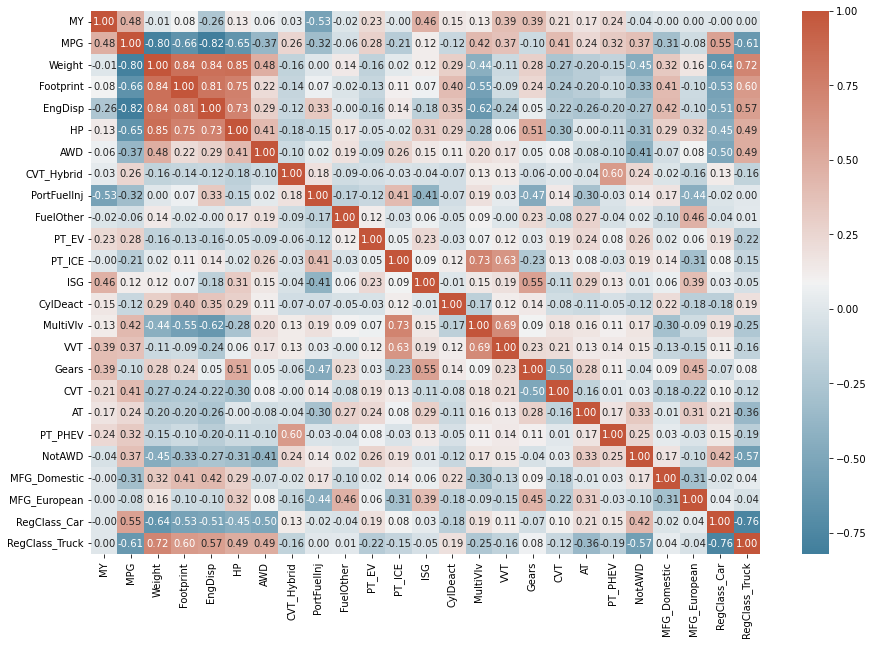

In [12]:
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()

### Visualize relationship between independent variables and dependent variable (2-Cycle MPG)

#### Visualization via histograms:

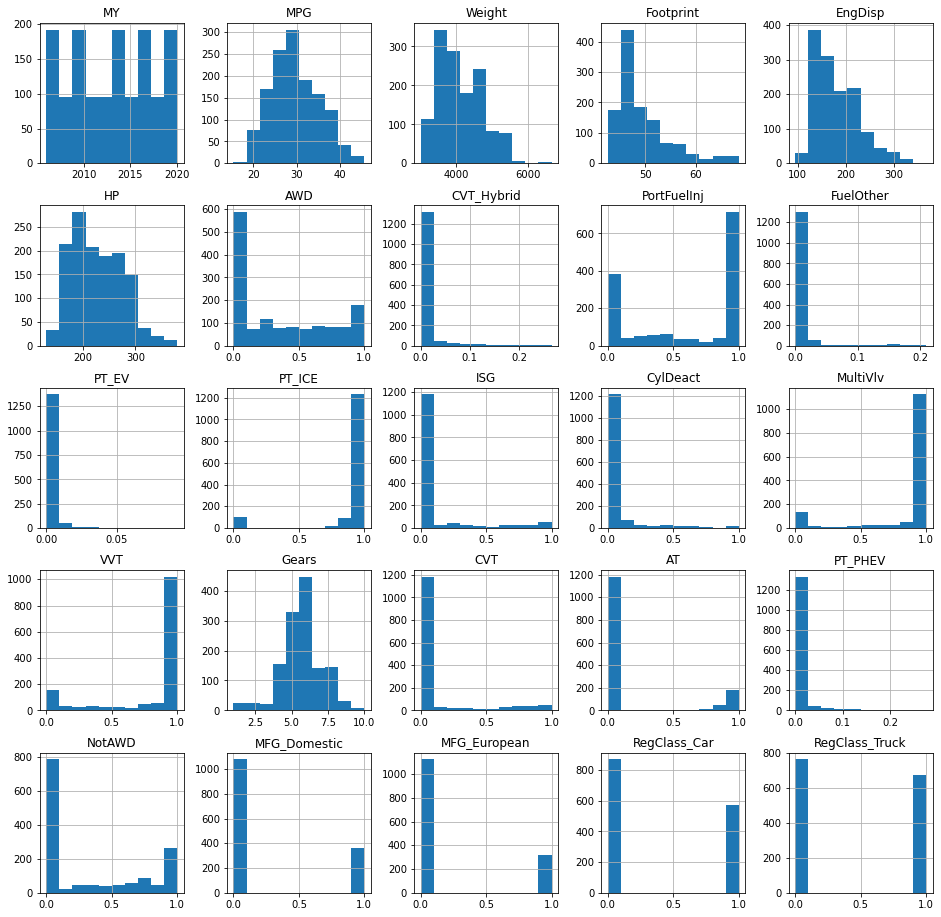

In [13]:
df.hist(figsize=(16,16))
plt.show() 

**Observations:**

#### Visualization via scatter plots:

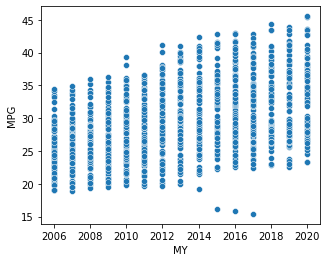

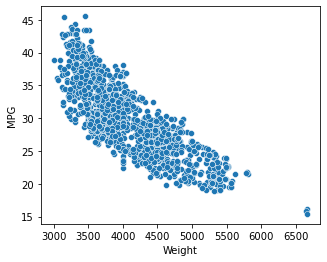

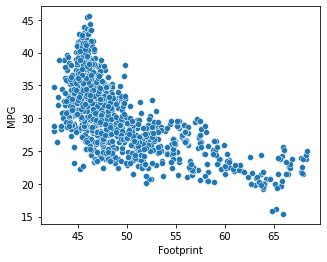

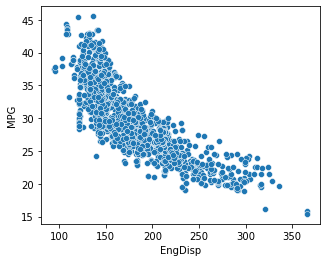

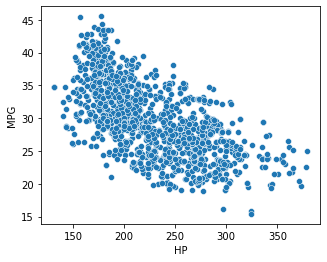

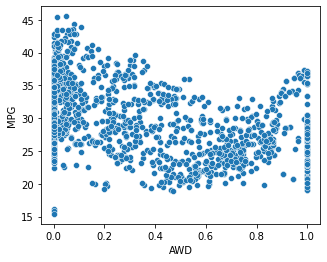

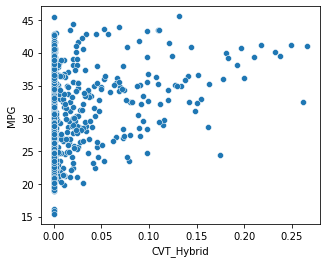

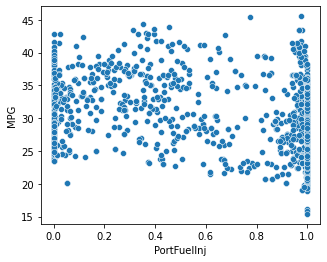

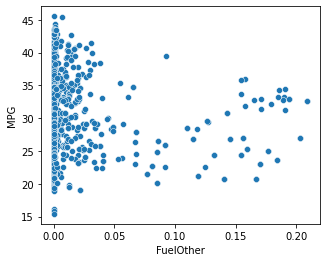

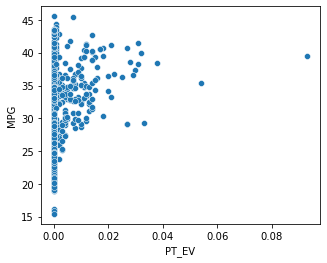

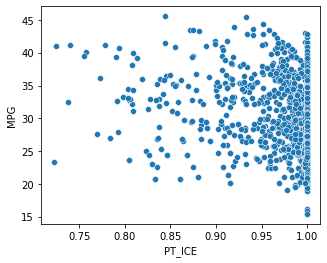

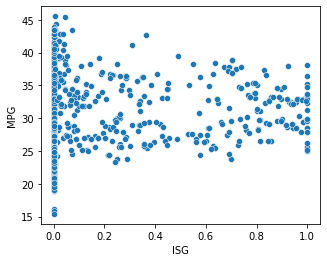

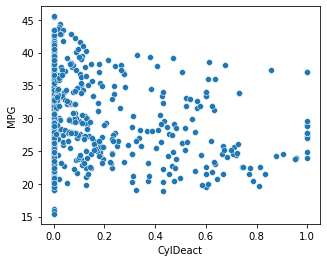

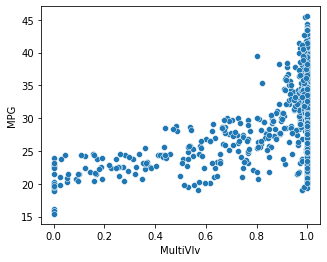

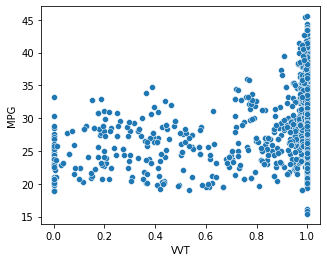

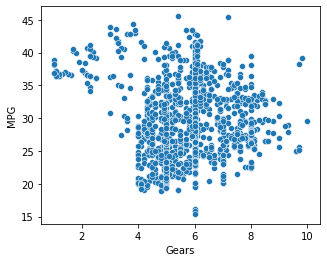

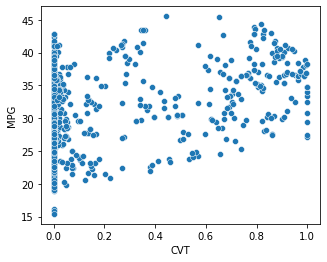

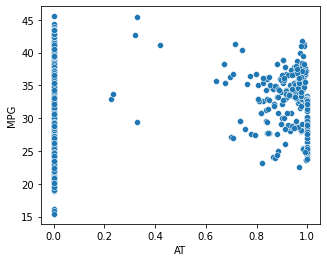

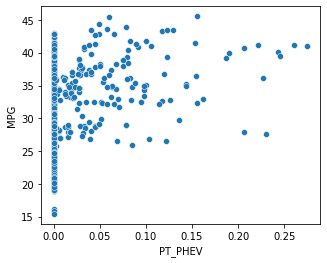

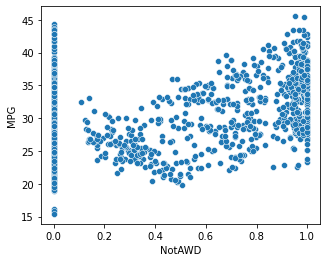

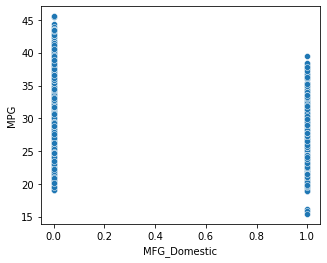

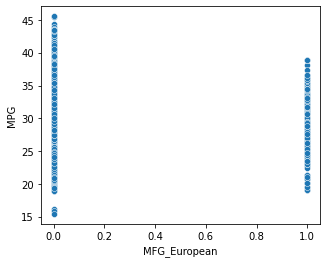

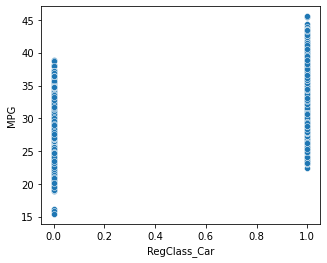

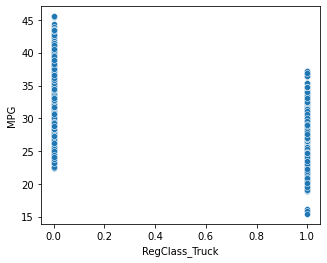

In [14]:
for col in df.drop(columns = ['MPG']).columns:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x = col, y = 'MPG', data = df)
    plt.show()

**Observations:**

#### OLS model with all variables

In [15]:
# Drop any rows that have NaN values
df = df.dropna(how='any') 

# Get the model summary
model0 = smf.ols('MPG ~ ' + '+'.join(df.columns.difference(['MPG'])), data=df,missing='drop').fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     573.9
Date:                Fri, 24 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:50:55   Log-Likelihood:                -2098.5
No. Observations:                1150   AIC:                             4247.
Df Residuals:                    1125   BIC:                             4373.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -649.3003     41.983    -15.466      0.000    -731.674    -566.926
AT                -0.0303      0.159     -0.191      0.849      -0.342       0.281
AWD               -0.5996      0.208     -2.878      0.004      -1.008      -0.191
CVT                2.9942      0.248     12.056      0.000       2.507       3.481
CVT_Hybrid        14.3950      2.953      4.874      0.000       8.601      20.189
CylDeact           1.9638      0.277      7.090      0.000       1.420       2.507
EngDisp           -0.0332      0.004     -7.951      0.000      -0.041      -0.025
Footprint          0.1082      0.022      4.871      0.000       0.065       0.152
FuelOther          1.2812      3.398      0.377      0.706      -5.386       7.948
Gears             -0.2009      0.056     -3.570      0.000      -0.311      -0.090
HP                -0.0066      0.003     -2.019      0.044      -0.013      -0.000
ISG                0.3587      0.279      1.284      0.200      -0.190       0.907
MFG_Domestic      -0.7955      0.170     -4.692      0.000      -1.128      -0.463
MFG_European      -0.4519      0.256     -1.762      0.078      -0.955       0.051
MY                 0.3532      0.021     17.015      0.000       0.312       0.394
MultiVlv          -1.8030      0.438     -4.120      0.000      -2.662      -0.944
NotAWD             0.5485      0.159      3.439      0.001       0.236       0.861
PT_EV             20.9216      9.618      2.175      0.030       2.050      39.793
PT_ICE           -10.2465      2.992     -3.424      0.001     -16.118      -4.375
PT_PHEV           -0.5038      2.290     -0.220      0.826      -4.997       3.989
PortFuelInj       -1.1699      0.188     -6.208      0.000      -1.540      -0.800
RegClass_Car       0.6813      0.151      4.510      0.000       0.385       0.978
RegClass_Truck    -0.3117      0.182     -1.711      0.087      -0.669       0.046
VVT                1.2337      0.267      4.629      0.000       0.711       1.757
Weight            -0.0043      0.000    -15.111      0.000      -0.005      -0.004
==============================================================================
Omnibus:                       16.011   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.178
Skew:                           0.008   Prob(JB):                     1.25e-06
Kurtosis:                       3.753   Cond. No.                     4.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# Forwards regression model
def forward_regression(data, response,
                       initial_list=[], 
                       threshold_in=0.01, 
                       verbose=True):
    
    y=df[response]
    X=df.drop(response, axis=1)
    
    #initial_list = []
    included = list(initial_list)
    
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
            #print(new_pval)
        best_pval = new_pval.min()
        
        if best_pval < threshold_in:
            best_index = new_pval.argmin()
            best_feature = new_pval.index[best_index]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add   with p-value {}, {}'.format(best_feature, best_pval))

        if not changed:
            print('\n Completed run: Breaking the loop,')
            break

    return model

forward_selected_model=forward_regression(df,'MPG')
forward_selected_model.summary()

Add   with p-value Weight, 7.411073572086723e-292
Add   with p-value MY, 1.0054678696739931e-185
Add   with p-value PT_ICE, 1.1724722904020868e-34
Add   with p-value CVT, 7.377059078313625e-37
Add   with p-value PortFuelInj, 1.1115359976053608e-16
Add   with p-value CVT_Hybrid, 4.5664898685938575e-18
Add   with p-value AWD, 3.054479014897595e-14
Add   with p-value HP, 1.4085608181308012e-11
Add   with p-value CylDeact, 2.5937869719234116e-10
Add   with p-value EngDisp, 2.6725611557674566e-10
Add   with p-value Footprint, 4.511494655697988e-07
Add   with p-value RegClass_Car, 1.3120731238528264e-07
Add   with p-value VVT, 3.7549063509221146e-06
Add   with p-value NotAWD, 0.00022205137409180603
Add   with p-value Gears, 0.0002076614252598637
Add   with p-value MultiVlv, 0.0027325045213098093
Add   with p-value MFG_Domestic, 7.045729370326702e-06

 Completed run: Breaking the loop,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     764.5
Date:                Fri, 24 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:50:57   Log-Likelihood:                -2101.8
No. Observations:                1150   AIC:                             4242.
Df Residuals:                    1131   BIC:                             4337.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -670.2525     38.293    -17.503      0.000    -745.386    -595.119
Weight          -0.0046      0.000    -18.664      0.000      -0.005      -0.004
MY               0.3635      0.019     18.952      0.000       0.326       0.401
PT_ICE          -9.8861      1.314     -7.522      0.000     -12.465      -7.307
CVT              3.0541      0.241     12.654      0.000       2.580       3.528
PortFuelInj     -1.1364      0.181     -6.276      0.000      -1.492      -0.781
CVT_Hybrid      14.8935      1.968      7.566      0.000      11.031      18.756
AWD             -0.6212      0.197     -3.153      0.002      -1.008      -0.235
HP              -0.0069      0.003     -2.607      0.009      -0.012      -0.002
CylDeact         2.0050      0.272      7.362      0.000       1.471       2.539
EngDisp         -0.0327      0.003     -9.670      0.000      -0.039      -0.026
Footprint        0.1169      0.020      5.716      0.000       0.077       0.157
RegClass_Car     0.7340      0.141      5.194      0.000       0.457       1.011
VVT              1.2580      0.258      4.879      0.000       0.752       1.764
NotAWD           0.5668      0.155      3.655      0.000       0.263       0.871
Gears           -0.1961      0.055     -3.558      0.000      -0.304      -0.088
MultiVlv        -1.7783      0.403     -4.417      0.000      -2.568      -0.988
MFG_Domestic    -0.6401      0.142     -4.521      0.000      -0.918      -0.362
PT_EV           22.4214      9.424      2.379      0.018       3.932      40.911
==============================================================================
Omnibus:                       16.240   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.728
Skew:                          -0.003   Prob(JB):                     9.53e-07
Kurtosis:                       3.761   Cond. No.                     3.95e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Backwards regression model
def backward_regression(data, response,
                           initial_list=[], 
                           threshold_out = 0.01):
    
    y=df[response]
    X=df.drop(response, axis=1)

    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            print('Remove   with p-value {}, {}'.format(worst_feature, worst_pval ))

        if not changed:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            print('\n Completed run: Breaking the loop,')
            break
            
    return model

backward_selected_model=backward_regression(df,'MPG')
backward_selected_model.summary()


Remove   with p-value AT, 0.8487143353643396
Remove   with p-value PT_PHEV, 0.8208594441531942
Remove   with p-value FuelOther, 0.5677999190813223
Remove   with p-value ISG, 0.22052107968591314
Remove   with p-value MFG_European, 0.127690744464223
Remove   with p-value RegClass_Truck, 0.144290987578595
Remove   with p-value PT_EV, 0.017512498550715818
Remove   with p-value HP, 0.019321968411566276

 Completed run: Breaking the loop,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     852.5
Date:                Fri, 24 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:50:57   Log-Likelihood:                -2107.4
No. Observations:                1150   AIC:                             4249.
Df Residuals:                    1133   BIC:                             4335.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -682.8396     38.003    -17.968      0.000    -757.404    -608.275
MY               0.3705      0.019     19.479      0.000       0.333       0.408
Weight          -0.0048      0.000    -20.291      0.000      -0.005      -0.004
Footprint        0.1098      0.020      5.387      0.000       0.070       0.150
EngDisp         -0.0369      0.003    -12.553      0.000      -0.043      -0.031
AWD             -0.7561      0.192     -3.945      0.000      -1.132      -0.380
CVT_Hybrid      14.3407      1.933      7.418      0.000      10.548      18.134
PortFuelInj     -1.0136      0.175     -5.796      0.000      -1.357      -0.670
PT_ICE         -10.2094      1.303     -7.833      0.000     -12.767      -7.652
CylDeact         2.0375      0.273      7.475      0.000       1.503       2.572
MultiVlv        -2.1386      0.381     -5.607      0.000      -2.887      -1.390
VVT              1.1920      0.258      4.626      0.000       0.686       1.698
Gears           -0.2631      0.049     -5.345      0.000      -0.360      -0.166
CVT              3.0439      0.239     12.728      0.000       2.575       3.513
NotAWD           0.5960      0.152      3.915      0.000       0.297       0.895
MFG_Domestic    -0.6820      0.141     -4.836      0.000      -0.959      -0.405
RegClass_Car     0.6627      0.138      4.813      0.000       0.393       0.933
==============================================================================
Omnibus:                       17.352   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.164
Skew:                           0.028   Prob(JB):                     2.82e-07
Kurtosis:                       3.791   Cond. No.                     3.90e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Remove all rows with Predicted value as NaN
df['predicted']=model0.fittedvalues
df = df[np.isfinite(df['predicted'])]

In [19]:
# Find MAE, MSE, RMSE and MAPE
mae = metrics.mean_absolute_error(df['MPG'], df['predicted'])
mse = metrics.mean_squared_error(df['MPG'], df['predicted'])

def mean_absolute_percentage_error(y_true, y_pred):    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE is:\t\t', mae)
print('MSE is:\t\t', mse) 
print('RMSE is:\t', sqrt(mse))
print('MAPE is:\t', mean_absolute_percentage_error(np.exp(df['MPG']), np.exp(df['predicted'])))

MAE is:		 1.147098366569197
MSE is:		 2.2518762377214525
RMSE is:	 1.5006252822478543
MAPE is:	 287.57657298371953


In [20]:
# Check Linear Regression assumptions using qq plot and residual plots.
df['resid']=pd.DataFrame(model0.resid)
df['std_resid']=model0.get_influence().resid_studentized_internal
df.head(2)

,MY,MPG,Weight,Footprint,EngDisp,HP,AWD,CVT_Hybrid,PortFuelInj,FuelOther,...,AT,PT_PHEV,NotAWD,MFG_Domestic,MFG_European,RegClass_Car,RegClass_Truck,predicted,resid,std_resid
192,2008,20.87824,5256.952,63.19281,298.1435,276.7135,0.506,0.000,1.0,0.0,...,0.0,0.0,0.0,1,0,0,1,19.601205,1.277035,0.853600
193,2009,20.80280,5325.399,64.27464,304.7528,290.5567,0.509,0.005,1.0,0.0,...,0.0,0.0,0.0,1,0,0,1,19.612840,1.189960,0.796032


#### QQ Plot and Residual Plot

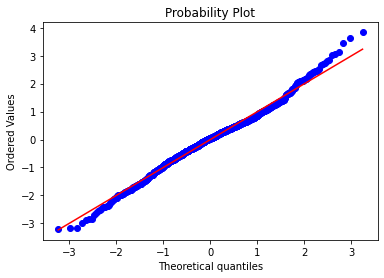

In [21]:
# Create QQ plot with standard residual
stats.probplot(df['std_resid'], dist="norm", plot=pylab)
plt.show()

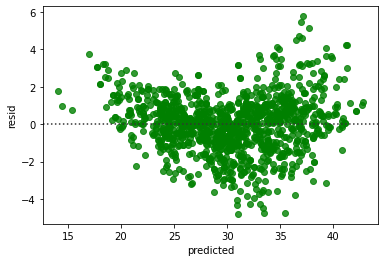

In [22]:
# Create residual plot with the predicted value
sns.residplot(x=df['predicted'], y=df['resid'],   color="g")
plt.show()